In [2]:
!pip install sentinelhub

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.8/249.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.0 MB/s eta 0:00:00
  Created wheel for utm: filename=utm-0.7.0-py3-none-any.whl size=6085 sha256=066c590ae9082e6ef813fd9bfcc8d40197b1c7734d6897a10add37707f6d143e
  Stored in directory: /root/.cache/pip/wheels/2f/a1/c8/543df0e8f5e824c3e92a432e32deb9cd89ae686095ee8cfcbe
Successfully built utm


In [3]:
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
from PIL import Image
import io
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
from __future__ import annotations

from typing import Any

from sentinelhub import SHConfig

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

def plot_image(
    image: np.ndarray, factor: float = 1.0, clip_range: tuple[float, float] | None = None, **kwargs: Any
) -> None:
    """Utility function for plotting RGB images."""
    _, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

CLIENT_ID = "b793056a-2cc8-4a3c-b365-1a4e219fc17a"
CLIENT_SECRET = "EzK1YOACy43LCbiZGXMuYlKvPbI44gOy"

In [4]:
current_path = os.getcwd()
print(current_path)

/content


In [79]:


config = SHConfig()
config.sh_client_id = CLIENT_ID
config.sh_client_secret = CLIENT_SECRET
config.sh_url = 'https://services.sentinel-hub.com/api/v1/process'
config.sh_oauth_url = 'https://services.sentinel-hub.com/oauth2/token'

config.save()

betsiboka_coords_wgs84 = (26.16, 16.15, 26.51, 15.58)
resolution = 60
betsiboka_bbox = BBox(bbox=betsiboka_coords_wgs84, crs=CRS.WGS84)
time_interval = ("2020-06-01", "2020-06-30")
betsiboka_size = bbox_to_dimensions(betsiboka_bbox, resolution=resolution)


          0   1   2
0        99  49  39
1        99  50  39
2        99  50  39
3        99  49  39
4       100  49  39
...     ...  ..  ..
658767   97  58  43
658768   96  58  43
658769   96  58  43
658770  100  61  45
658771   98  61  45

[658772 rows x 3 columns]
[array([[[ 99,  49,  39],
        [ 99,  50,  39],
        [ 99,  50,  39],
        ...,
        [107,  67,  48],
        [106,  66,  48],
        [107,  67,  50]],

       [[ 99,  49,  39],
        [ 97,  49,  39],
        [ 97,  48,  39],
        ...,
        [107,  67,  48],
        [105,  66,  48],
        [107,  66,  48]],

       [[ 99,  49,  39],
        [ 98,  49,  39],
        [ 99,  49,  39],
        ...,
        [105,  66,  48],
        [107,  65,  47],
        [104,  64,  46]],

       ...,

       [[ 92,  51,  40],
        [ 96,  52,  40],
        [ 97,  51,  39],
        ...,
        [ 95,  57,  42],
        [ 93,  56,  42],
        [ 99,  61,  46]],

       [[ 93,  50,  39],
        [ 97,  52,  40],
        [

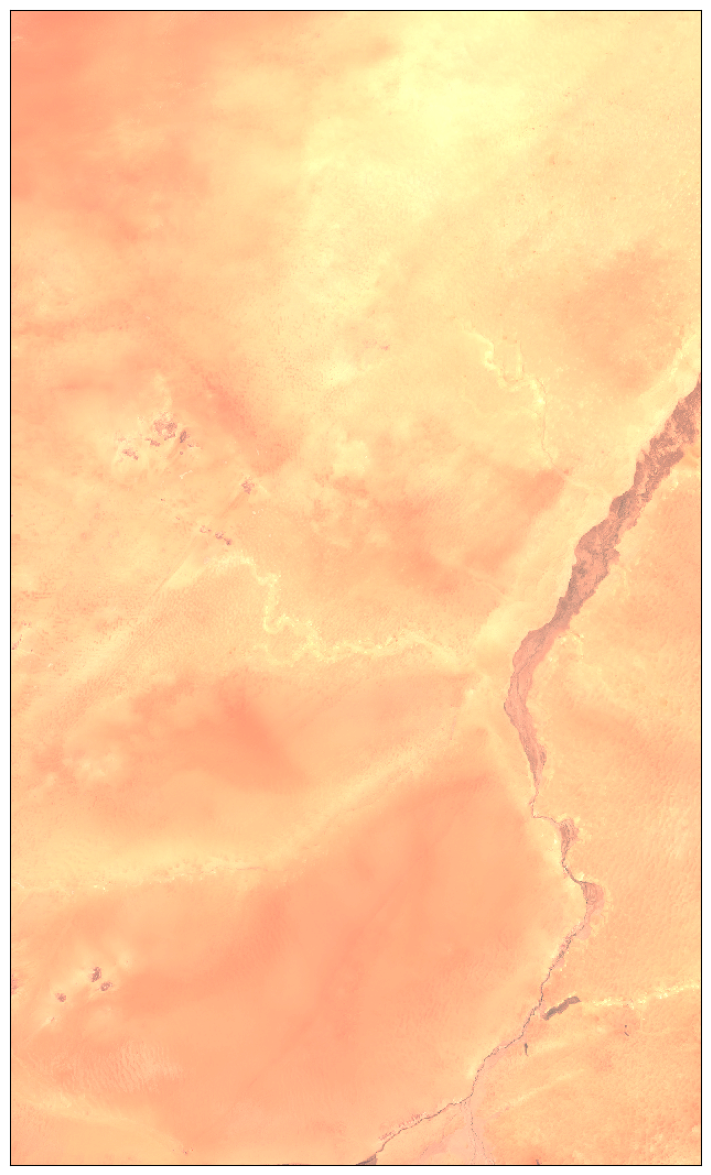

In [80]:

evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2020-06-01", "2020-06-30"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config,
    data_folder="/content/data_folder"
)

true_color_response = request_true_color.get_data()

true_color_img = request_true_color.get_data(save_data=True)
# image = Image.open(true_color_img[0])
image = Image.fromarray(true_color_img[0])

image_data = np.array(image)

import pandas as pd

df = pd.DataFrame(image_data.reshape(-1, image_data.shape[-1] if len(image_data.shape) == 3 else 1))

print(df)


print(true_color_response)

#print(all_bands_response)

image = true_color_response[0]
print(image.shape)
plot_image(image, factor = 3.5 / 255, clip_range = (0, 1))

In [14]:
# !pip install pandas
!pip install rasterio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 32.8 MB/s eta 0:00:00


In [15]:
from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
    SHConfig,
)
from PIL import Image
import numpy as np
import pandas as pd
import os
import rasterio
from datetime import date
from dateutil.relativedelta import relativedelta


# Set your SentinelHub instance configuration (e.g., client ID, secret)
CLIENT_ID = "b793056a-2cc8-4a3c-b365-1a4e219fc17a"
CLIENT_SECRET = "EzK1YOACy43LCbiZGXMuYlKvPbI44gOy"

# Set up SentinelHub config
config = SHConfig()
config.sh_client_id = CLIENT_ID
config.sh_client_secret = CLIENT_SECRET
config.sh_url = 'https://services.sentinel-hub.com/api/v1/process'
config.sh_oauth_url = 'https://services.sentinel-hub.com/oauth2/token'

config.save()


# Define your bounding box and size (you can replace these with your values)
# Example: Bounding box for Betsiboka region in Madagascar (replace with your own)
betsiboka_coords_wgs84 = (45.0, -17.0, 45.5, -16.5)  # [min_lon, min_lat, max_lon, max_lat]
resolution = 60
betsiboka_bbox = BBox(bbox=betsiboka_coords_wgs84, crs=CRS.WGS84)
betsiboka_size = bbox_to_dimensions(betsiboka_bbox, resolution=60)  # You can set the resolution

# Define the time interval for the time series
#time_interval = ("2020-06-01", "2024-11-18")



# forming sequence of time intervals for time series data

today = date.today()

time_intervals = []

for month in range(1,13):
    start = today - relativedelta(months=month)
    end = start + relativedelta(months=1)
    start = start.strftime("%Y-%m-%d")
    end = end.strftime("%Y-%m-%d")
    time_interval = (start, end)
    time_intervals.insert(0, time_interval)

#time_interval = ("2024-06-03", "2024-11-18")

for time_interval in time_intervals:
    print(time_interval)




# Define the evalscript for true color images (you can adjust it as needed)
evalscript_sentinel_2 = """
//VERSION=3
function setup() {
    return {
        input: ["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"],
        output: { bands: 13 }
    };
}

function evaluatePixel(sample) {
    return [sample.B02,
            sample.B03,
            sample.B04,
            sample.B05,
            sample.B06,
            sample.B07,
            sample.B08,
            sample.B8A,
            sample.B11,
            sample.B12,
            (sample.B8 - sample.B4) / (sample.B8 + sample.B4),
            (sample.B3 - sample.B8) / (sample.B3 + sample.B8),
            (sample.B4 - sample.B3) / sample.B8,

        ];
}
"""

evalscript_sentinel_1 = """
//VERSION=3
function setup() {
    return {
        input: ["VV", "VH"],
        output: { bands: 2 }
    };
}

function evaluatePixel(sample) {
    return [sample.VV,
            sample.VH
        ];
}
"""

data_folder = "data"
os.makedirs(data_folder, exist_ok=True)




time_series_df = pd.DataFrame()

for time_interval in time_intervals:

    # Create SentinelHub request for time series data from Sentinel-2
    request_sentinel_2_bands = SentinelHubRequest(
        evalscript=evalscript_sentinel_2,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                time_interval=time_interval,
                #mosaicking_order='TILE',
                mosaicking_order=MosaickingOrder.LEAST_CC
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=betsiboka_bbox,
        size=betsiboka_size,
        config=config,
        data_folder=data_folder
    )

    # Create sentinel

    # Get the time series data (download the TIFF)

    sentinel_2_bands_img = request_sentinel_2_bands.get_data(save_data=True)

    # Open the TIFF image using PIL

    print(type(sentinel_2_bands_img))
    print( sentinel_2_bands_img)
    #image = Image.open(true_color_img)

    # Convert the image to a numpy array
    image_data = np.array(sentinel_2_bands_img)

    print("Image Data")
    print(image_data.shape)
    print(image_data)

    image_squeezed = image_data.squeeze()

    #image_flattened = image_squeezed.reshape(-1, 3)

    image_flattened = image_squeezed.reshape(-1, 13)

    # Convert the numpy array to a pandas DataFrame
    # If the image is RGB, the shape will be (height, width, 3), flatten it to (height*width, 3)
    sentinel_2_df = pd.DataFrame(image_flattened, columns=[
        f'B02{time_interval}',
        f'B03{time_interval}',
        f'B04{time_interval}',
        f'B05{time_interval}',
        f'B06{time_interval}',
        f'B07{time_interval}',
        f'B08{time_interval}',
        f'B8A{time_interval}',
        f'B11{time_interval}',
        f'B12{time_interval}',
        f'NDVI{time_interval}',
        f'NDWI{time_interval}',
        f'PSRI{time_interval}',
    ])


    # repeat process for sentinel-1 api (for bands VV and VH)

    request_sentinel_1_bands = SentinelHubRequest(
        evalscript=evalscript_sentinel_1,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL1_IW,
                time_interval=time_interval,
                #mosaicking_order='TILE',
                #mosaicking_order=MosaickingOrder.LEAST_CC
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=betsiboka_bbox,
        size=betsiboka_size,
        config=config,
        data_folder=data_folder
    )

    print(f"type returned from SentinelHubRequest {type(request_sentinel_1_bands)}")

    # Get the time series data (download the TIFF)

    sentinel_1_bands_img = request_sentinel_1_bands.get_data(save_data=True)

    # Convert the image to a numpy array
    image_data = np.array(sentinel_1_bands_img)

    print("Image Data")
    print(image_data.shape)
    print(image_data)

    image_squeezed = image_data.squeeze()

    image_flattened = image_squeezed.reshape(-1, 2)

    # Convert the numpy array to a pandas DataFrame
    # If the image is RGB, the shape will be (height, width, 3), flatten it to (height*width, 3)
    sentinel_1_df = pd.DataFrame(image_flattened, columns=[f'VV{time_interval}', f'VH{time_interval}'])

    combined_sentinel_df = pd.concat([sentinel_2_df, sentinel_1_df], axis=1)

    time_series_df = pd.concat([time_series_df, combined_sentinel_df], axis=1)
    # Display the first few rows of the DataFrame
    print(time_series_df)

print('done')

## TO DO: extract functions from this giant ass block of code

('2023-11-19', '2023-12-19')
('2023-12-19', '2024-01-19')
('2024-01-19', '2024-02-19')
('2024-02-19', '2024-03-19')
('2024-03-19', '2024-04-19')
('2024-04-19', '2024-05-19')
('2024-05-19', '2024-06-19')
('2024-06-19', '2024-07-19')
('2024-07-19', '2024-08-19')
('2024-08-19', '2024-09-19')
('2024-09-19', '2024-10-19')
('2024-10-19', '2024-11-19')
<class 'list'>
[array([[[31, 32, 47, ...,  0,  0,  0],
        [29, 27, 32, ...,  0,  0,  0],
        [30, 29, 30, ...,  0,  0,  0],
        ...,
        [26, 24, 19, ...,  0,  0,  0],
        [26, 27, 21, ...,  0,  0,  0],
        [26, 26, 20, ...,  0,  0,  0]],

       [[31, 30, 44, ...,  0,  0,  0],
        [30, 28, 35, ...,  0,  0,  0],
        [32, 31, 40, ...,  0,  0,  0],
        ...,
        [29, 28, 26, ...,  0,  0,  0],
        [26, 25, 19, ...,  0,  0,  0],
        [26, 26, 20, ...,  0,  0,  0]],

       [[31, 32, 45, ...,  0,  0,  0],
        [30, 27, 30, ...,  0,  0,  0],
        [31, 31, 37, ...,  0,  0,  0],
        ...,
        

KeyboardInterrupt: 

In [16]:
### HOLDS EVALSCRIPTS

evalscript_sentinel_2 = """
//VERSION=3
function setup() {
    return {
        input: ["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"],
        output: { bands: 13 }
    };
}

function evaluatePixel(sample) {
    return [sample.B02,
            sample.B03,
            sample.B04,
            sample.B05,
            sample.B06,
            sample.B07,
            sample.B08,
            sample.B8A,
            sample.B11,
            sample.B12,
            (sample.B08 - sample.B04) / (sample.B08 + sample.B04),
            (sample.B03 - sample.B08) / (sample.B03 + sample.B08),
            (sample.B04 - sample.B03) / sample.B08,

        ];
}
"""

evalscript_sentinel_1 = """
    //VERSION=3
    function setup() {
        return {
            input: ["VV", "VH"],
            output: { bands: 2 }
        };
    }

    function evaluatePixel(sample) {
        return [sample.VV,
                sample.VH
            ];
}
"""

In [17]:
### imports and util functions

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
    SHConfig,
)
from PIL import Image
import numpy as np
import pandas as pd
import os
import rasterio
from datetime import date
from dateutil.relativedelta import relativedelta


def bbox_generator(coords_wgs84, resolution=60):
    bbox = BBox(bbox=coords_wgs84, crs=CRS.WGS84)
    size = bbox_to_dimensions(bbox, resolution)  # You can set the resolution
    return bbox, size


def get_time_intervals():
    today = date.today()
    time_intervals = []
    for month in range(1,13):
        start = today - relativedelta(months=month)
        end = start + relativedelta(months=1)
        start = start.strftime("%Y-%m-%d")
        end = end.strftime("%Y-%m-%d")
        time_interval = (start, end)
        time_intervals.insert(0, time_interval)
    return time_intervals

def generate_sentinel_hub_request(bbox, size, time_interval, datafolder, evalscript, data_collection): ##considered turning this into a class
    return SentinelHubRequest(
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=data_collection,
                time_interval=time_interval,
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=bbox,
        size=size,
        config=config,
        data_folder=data_folder
    )

def generate_sentinel_1_request(bbox, size, time_interval, datafolder):
    return generate_sentinel_hub_request(bbox, size, time_interval, datafolder, evalscript=evalscript_sentinel_1, data_collection=DataCollection.SENTINEL1_IW)

def generate_sentinel_2_request(bbox, size, time_interval, datafolder):
    return generate_sentinel_hub_request(bbox, size, time_interval, datafolder, evalscript=evalscript_sentinel_2, data_collection=DataCollection.SENTINEL2_L1C)

def convert_request_to_df(request, no_of_bands, columns):
    image = request.get_data(save_data=True)

    # Convert the image to a numpy array
    image_data = np.array(image)
    image_squeezed = image_data.squeeze()
    image_flattened = image_squeezed.reshape(-1, no_of_bands)

    # Convert the numpy array to a pandas DataFrame
    df = pd.DataFrame(image_flattened, columns=columns)
    return df



In [18]:
def get_time_series_df_from_bbox(bbox_coords_wgs84, resolution=60):
    bbox, size = bbox_generator(bbox_coords_wgs84, resolution)
    time_intervals = get_time_intervals()

    data_folder = "data"
    os.makedirs(data_folder, exist_ok=True)




    band_df_list = []

    for _ in range(1, 16):
        band_df_list.append(pd.DataFrame())


    print(f"Length of bands list: {len(band_df_list)}")
    '''
    b02_df = pd.DataFrame()
    b03_df = pd.DataFrame()
    b04_df = pd.DataFrame()
    b05_df = pd.DataFrame()
    b06_df = pd.DataFrame()
    b07_df = pd.DataFrame()
    b08_df = pd.DataFrame()
    b8a_df = pd.DataFrame()
    b11_df = pd.DataFrame()
    b12_df = pd.DataFrame()
    ndvi_df = pd.DataFrame()
    ndwi_df = pd.DataFrame()
    psri_df = pd.DataFrame()
    vv_df = pd.DataFrame()
    vh_df = pd.DataFrame()
    '''

    time_series_df = pd.DataFrame()

    for time_interval in time_intervals:
        sentinel_2_request = generate_sentinel_2_request(bbox, size, time_interval, data_folder)
        sentinel_2_columns = [
            f'B02{time_interval}',
            f'B03{time_interval}',
            f'B04{time_interval}',
            f'B05{time_interval}',
            f'B06{time_interval}',
            f'B07{time_interval}',
            f'B08{time_interval}',
            f'B8A{time_interval}',
            f'B11{time_interval}',
            f'B12{time_interval}',
            f'NDVI{time_interval}',
            f'NDWI{time_interval}',
            f'PSRI{time_interval}',
        ]
        sentinel_2_df = convert_request_to_df(sentinel_2_request, 13, sentinel_2_columns)

        sentinel_1_request = generate_sentinel_1_request(bbox, size, time_interval, data_folder)
        sentinel_1_columns = [
            f'VV{time_interval}',
            f'VH{time_interval}'
        ]
        sentinel_1_df = convert_request_to_df(sentinel_1_request, 2, sentinel_1_columns)

        for index, column_name in enumerate(sentinel_2_df.columns):
            column_data = sentinel_2_df[column_name]
            new_series = pd.Series(column_data, name=column_name)
            band_df_list[index] = pd.concat([band_df_list[index], new_series], axis=1)

        for index, column_name in enumerate(sentinel_1_df.columns):
            column_data = sentinel_1_df[column_name]
            new_series = pd.Series(column_data, name=column_name)
            band_df_list[index + 13] = pd.concat([band_df_list[index + 13], new_series], axis=1)

        combined_sentinel_df = pd.concat([sentinel_2_df, sentinel_1_df], axis=1)
        #time_series_df = pd.concat([time_series_df, combined_sentinel_df], axis=1)
        #print(time_series_df)
        print(f"Making request for {time_interval}")



    ## combine all the separate band dfs together
    for df in band_df_list:
        time_series_df = pd.concat([time_series_df, df], axis=1)

    #print("Final result")
    #print(time_series_df)
    return time_series_df




In [19]:
df = get_time_series_df_from_bbox((26.16, 16.15, 26.51, 15.58))

print(df)
print(df.columns[:])
print('done')


Length of bands list: 15
Making request for ('2023-11-19', '2023-12-19')
Making request for ('2023-12-19', '2024-01-19')
Making request for ('2024-01-19', '2024-02-19')
Making request for ('2024-02-19', '2024-03-19')
Making request for ('2024-03-19', '2024-04-19')
Making request for ('2024-04-19', '2024-05-19')
Making request for ('2024-05-19', '2024-06-19')
Making request for ('2024-06-19', '2024-07-19')
Making request for ('2024-07-19', '2024-08-19')
Making request for ('2024-08-19', '2024-09-19')
Making request for ('2024-09-19', '2024-10-19')
Making request for ('2024-10-19', '2024-11-19')
        B02('2023-11-19', '2023-12-19')  B02('2023-12-19', '2024-01-19')  \
0                                    37                               39   
1                                    38                               40   
2                                    39                               40   
3                                    38                               39   
4                  

In [20]:
!pip install geopandas
!pip install scikit-learn
!pip install seaborn
!pip install pytorch-lightning
!pip install torch
!pip install torchmetrics
!pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 35.0 MB/s eta 0:00:00


In [22]:
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.image as mpimg
import seaborn as sns

import torch

import torch.autograd as autogradimport
import torch.nn as nn

import pytorch_lightning as pl

import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from multiprocessing import cpu_count
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.functional import accuracy
from sklearn.metrics import classification_report, confusion_matrix


In [23]:
from torchmetrics import Accuracy
import torch.optim as optim

class SurfacePredictor(pl.LightningModule):

  def __init__(self, n_features: int, n_classes: int):
    super() .__init__()
    self.model = SequenceModel(n_features, n_classes)
    self.criterion = nn.CrossEntropyLoss()
    self.accuracy = Accuracy(task='multiclass', num_classes=n_classes)
    self.n_classes = n_classes

  def forward(self, x, labels=None):
    output = self.model(x)
    loss = 0
    if labels is not None:
      loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    sequences = batch['sequence']
    labels = batch['label']

    loss, outputs = self(sequences, labels)
    predictions = torch.argmax(outputs, dim=1)
    step_accuracy = accuracy(predictions, labels, task='multiclass', num_classes=self.n_classes)


    self.log("train_loss", loss, prog_bar=True, logger=True)
    self.log("train_accuracy", step_accuracy, prog_bar=True, logger=True)
    return {"loss": loss, "accuracy" : step_accuracy}
  def validation_step(self, batch, batch_idx):
    sequences = batch['sequence']
    labels = batch['label']
    loss, outputs = self(sequences, labels)
    predictions = torch.argmax(outputs, dim=1)
    step_accuracy = accuracy(predictions, labels, task='multiclass', num_classes=self.n_classes)


    self.log("val_loss", loss, prog_bar=True, logger=True)
    self.log("val_accuracy", step_accuracy, prog_bar=True, logger=True)
    return {"loss": loss, "accuracy" : step_accuracy}

  def test_step(self, batch, batch_idx):
    sequences = batch['sequence']
    labels = batch['label']
    loss, outputs = self(sequences, labels)
    predictions = torch.argmax(outputs, dim=1)
    step_accuracy = accuracy(predictions, labels, task='multiclass', num_classes=self.n_classes)

    self.log("test_loss", loss, prog_bar=True, logger=True)
    self.log("test_accuracy", step_accuracy, prog_bar=True, logger=True)
    return {"loss": loss, "accuracy" : step_accuracy}

  def configure_optimizers(self):
    return optim.Adam(self.parameters(), lr=0.0001)

In [24]:
class SequenceModel(nn.Module):

  def __init__(self, n_features, n_classes, n_hidden=256, n_layers=3):
    super() .__init__()


    self.lstm = nn.LSTM(
        input_size = n_features,
        hidden_size = n_hidden,
        num_layers=n_layers,
        batch_first= True,
    )

    self.classifier = nn.Linear(n_hidden, n_classes)

  def forward(self, x):
    self.lstm.flatten_parameters()
    _, (hidden, _) = self.lstm(x)

    out = hidden[-1]
    return self.classifier(out)

In [35]:


trained_model = SurfacePredictor.load_from_checkpoint(
    checkpoint_path="best-checkpoint.ckpt",
    n_features=15,
    n_classes=10
)

trained_model.freeze()

In [26]:
from torch.utils.data import Dataset

class SurfaceDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence, label = self.sequences[idx]

        # Ensure sequence is numeric and convert to tensor
        sequence = torch.tensor(sequence.to_numpy().astype(float), dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        return dict(
        sequence=sequence,
        label=label
                    )

In [59]:
from scipy.interpolate import interp1d
result_dfs = []
X = df.astype(float)[:6500]
bands = ['B02', 'B03', 'B04' ,'B05' ,'B06' ,'B07' ,'B08', 'B8A', 'B11', 'B12', 'NDVI', 'NDWI',
 'PSRI', 'VV', 'VH']
df_meta = pd.read_csv('cyprus_2022_meta.csv')
id_to_code = {k:v for k,v in df_meta[['FIELD_ID','CROP_CODE']].values}
for index, row in X.iterrows():
    newdf = pd.DataFrame(index=range(40), columns=bands)

    for spectrum in bands:
        columns_with = [col for col in X.columns if spectrum in col]
        data_values = X.loc[index, columns_with].values
        x_values = range(len(data_values))
        new_size = 40
        new_x = np.linspace(0, len(data_values)-1, new_size)
        interp_func = interp1d(x_values, data_values, kind='linear')
        iterped = interp_func(new_x)
        newdf[spectrum] = iterped

    # Append the new DataFrame and corresponding y_train value to result_dfs
    # result_dfs.append((newdf, id_to_code.get(X.loc[index, "FIELD_ID"])))
    result_dfs.append(newdf)
    if index % 1000 == 0:
        print(index)


0
1000
2000
3000
4000
5000
6000


In [50]:
print(len(result_dfs))

6500


In [60]:
print(result_dfs[0])

          B02        B03         B04         B05         B06         B07  \
0   37.000000  48.000000   99.000000  108.000000  116.000000  121.000000   
1   37.564103  48.564103   99.846154  109.410256  117.410256  122.128205   
2   38.128205  49.128205  100.692308  110.820513  118.820513  123.256410   
3   38.692308  49.692308  101.538462  112.230769  120.230769  124.384615   
4   38.871795  50.000000  101.871795  112.871795  120.871795  124.871795   
5   38.589744  50.000000  101.589744  112.589744  120.589744  124.589744   
6   38.307692  50.000000  101.307692  112.307692  120.307692  124.307692   
7   38.025641  50.000000  101.025641  112.025641  120.025641  124.025641   
8   43.128205  57.435897  102.794872  112.769231  121.794872  127.846154   
9   48.769231  65.615385  104.769231  113.615385  123.769231  132.076923   
10  54.410256  73.794872  106.743590  114.461538  125.743590  136.307692   
11  55.948718  75.923077  107.384615  114.794872  126.384615  137.769231   
12  50.30769

In [61]:
from tqdm.auto import tqdm

# torch_tensor = torch.tensor(result_dfs, dtype=torch.float32)
tensor_list = [torch.tensor(df.values, dtype=torch.float32) for df in result_dfs]
torch_tensor = torch.stack(tensor_list)

predictions = []
labels = []

# Get the device the model is on
device = next(trained_model.parameters()).device

for item in tqdm(torch_tensor):
#   print(item)
  # sequence = item['sequence']
  sequence = item
  # label = item['label']

  # Move the sequence to the same device as the model
#   print(sequence.size())
  sequence = sequence.unsqueeze(dim=0)
#   print(sequence.size())
  _, output = trained_model(sequence)
  prediction = torch.argmax(output, dim=1)
  predictions.append(prediction.item())
  # labels.append(label.item())

  0%|          | 0/6500 [00:00<?, ?it/s]

In [62]:
print(predictions)

[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 

In [63]:
codeToName = [
 'LAND LYING FALLOW',
 'BARLEY',
 'WHEAT',
 'WINE VINEYARDS',
 'OLIVES',
 'CITRUS TREES',
 'TRADITIONAL TREES',
 'POTATOES',
 'DECIDUOUS FRUIT TREES',
 'PERMANENT GRASSLAND'
]